# Notebook for preprocessing the data

import necessary Libraries

It is important to set path for the python source code

In [1]:
import sys  
sys.path.insert(0, '../src')

import os
import numpy as np
import pandas as pd
import random

from glob import glob

import config

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as img

from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
random.seed(config.SEED)

## Load Input Data

### Load Image Index File

This function loads the index file for images. The index file also have other non-image features

In [3]:
def load_image_indices (root_dir=config.ROOT_PATH, data_dir=config.INPUT_DATA_DIR, index_file=config.INDEX_FILE) :
    
    '''
    Loads the input data indices
    Args:
      data_dir: Path to the input data dir
      root_dir: Path to project root dir
      index_file: File name with indices to Images
    Returns:
      ataFrame with input images
    '''
    
    indices = pd.read_csv(os.path.join(root_dir, data_dir, index_file))
    
    indices.drop(columns=['Unnamed: 11'], axis=1, inplace=True)
    
    indices.rename(columns={"OriginalImage[Width": "Width", "Height]": "Height", 
                            "OriginalImagePixelSpacing[x": "X", "y]": "Y", "Follow-up #": "Follow Up"}, inplace=True)
    
    return indices

### Load Image paths and add to index dataframe

In [4]:
def load_image_paths (df_indides=None, root_dir=config.ROOT_PATH, data_dir=config.INPUT_DATA_DIR) :
    
    '''
    Loads the input data
    Args:
      path: Path to the input data dit
    Returns:
      ataFrame with input images
    '''
    
    if not df_indides:
        df_indices = load_image_indices(root_dir=root_dir, data_dir=data_dir)
    
    image_paths = glob(os.path.join(root_dir, data_dir, 'images', '*.png'))
    
    if len(df_indices) == len(image_paths):
        df_indices['Image_path'] = df_indices['Image Index'].map(
            {os.path.basename(image_path): os.path.relpath(image_path) for image_path in image_paths})
        
    else:
        raise Exception('miamatch in index file and image count')
        
    return df_indices

### Get all unique image labels in a DF

In [5]:
def load_image_labels (df_indices) :
        
    labels = list(set([label for label_list in df_indices['Finding Labels'].str.split("|", expand = False) for label in label_list]))
    
    return labels

### Draw an image

In [6]:
def draw_image (df, i=random.randint(0,99999)) :
        
    if i >= len(df):
        i = len(df)-1
    plt.imshow(img.imread(df['Image_path'][i]), cmap = 'bone')
    plt.title(df['Finding Labels'][i])

In [7]:
def load_data():
    df_indices = load_image_paths()
    lst_labels = load_image_labels(df_indices)
    
    df_data    = df_indices[['Patient ID','Patient Age','Patient Gender',
                          'Follow Up','Image Index','Image_path','Finding Labels']]
    
    return df_data, lst_labels

In [8]:
def multi_hot_label(df_data, labels):
    mb = MultiLabelBinarizer(sparse_output=True)

    df_data = df_data.join(pd.DataFrame.sparse.from_spmatrix(mb.fit_transform(df_data['Finding Labels'].str.split("|", expand = False)),columns=mb.classes_,index=df_data.index))
    df_data.drop(columns=['Finding Labels'], axis=1, inplace=True)
    
    return df_data

### Split into Test and Train Set

In [9]:
def train_test_split(df_data, train_val_list_file=config.TRAIN_VAL_FILE, test_val_list_file=config.TEST_VAL_FILE,
                     root_dir=config.ROOT_PATH, data_dir=config.INPUT_DATA_DIR):
    
    with open(os.path.join(root_dir, data_dir, train_val_list_file)) as f:
        train_val_list = [x.strip() for x in f.readlines()]
    
    with open(os.path.join(root_dir, data_dir, test_val_list_file)) as f:
        test_val_list  = [x.strip() for x in f.readlines()]
        
    df_train = df_data[df_data['Image Index'].isin(train_val_list)]
    df_valid = df_data[df_data['Image Index'].isin(test_val_list)]    
    
    return df_train, df_valid

#### MAIN

In [10]:
df_data, labels = load_data()

In [11]:
df_data

,Patient ID,Patient Age,Patient Gender,Follow Up,Image Index,Image_path,Finding Labels
0,1,58,M,0,00000001_000.png,..\data\raw\images\00000001_000.png,Cardiomegaly
1,1,58,M,1,00000001_001.png,..\data\raw\images\00000001_001.png,Cardiomegaly|Emphysema
2,1,58,M,2,00000001_002.png,..\data\raw\images\00000001_002.png,Cardiomegaly|Effusion
3,2,81,M,0,00000002_000.png,..\data\raw\images\00000002_000.png,No Finding
4,3,81,F,0,00000003_000.png,..\data\raw\images\00000003_000.png,Hernia
...,...,...,...,...,...,...,...
112115,30801,39,M,1,00030801_001.png,..\data\raw\images\00030801_001.png,Mass|Pneumonia
112116,30802,29,M,0,00030802_000.png,..\data\raw\images\00030802_000.png,No Finding
112117,30803,42,F,0,00030803_000.png,..\data\raw\images\00030803_000.png,No Finding
112118,30804,30,F,0,00030804_000.png,..\data\raw\images\00030804_000.png,No Finding


#### Get all dinstinct target labels

In [12]:
labels

['No Finding',
 'Mass',
 'Consolidation',
 'Emphysema',
 'Cardiomegaly',
 'Hernia',
 'Pneumonia',
 'Nodule',
 'Fibrosis',
 'Pneumothorax',
 'Atelectasis',
 'Pleural_Thickening',
 'Effusion',
 'Infiltration',
 'Edema']

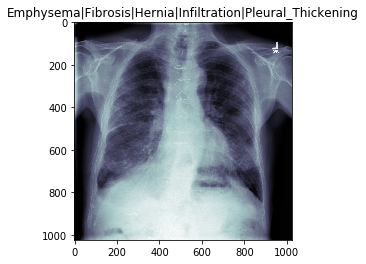

In [13]:
draw_image(df_data)

In [14]:
df_data = multi_hot_label(df_data, labels)
df_data

,Patient ID,Patient Age,Patient Gender,Follow Up,Image Index,Image_path,Atelectasis,Cardiomegaly,Consolidation,Edema,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,1,58,M,0,00000001_000.png,..\data\raw\images\00000001_000.png,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,58,M,1,00000001_001.png,..\data\raw\images\00000001_001.png,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,58,M,2,00000001_002.png,..\data\raw\images\00000001_002.png,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,81,M,0,00000002_000.png,..\data\raw\images\00000002_000.png,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,3,81,F,0,00000003_000.png,..\data\raw\images\00000003_000.png,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,30801,39,M,1,00030801_001.png,..\data\raw\images\00030801_001.png,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
112116,30802,29,M,0,00030802_000.png,..\data\raw\images\00030802_000.png,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
112117,30803,42,F,0,00030803_000.png,..\data\raw\images\00030803_000.png,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
112118,30804,30,F,0,00030804_000.png,..\data\raw\images\00030804_000.png,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [15]:
df_train, df_test = train_test_split(df_data)

In [16]:
### end ###